In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from statsmodels.formula import api
# import ptitprince
from statsmodels.stats.multitest import multipletests
from os.path import join as opj

from scipy.stats import trim_mean

import matplotlib as mpl
from matplotlib import colors
from matplotlib import cm

/home/javi/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
results_dir = "../results/desikan"
plot_dir = "../plots"

Path(plot_dir).mkdir(exist_ok=True, parents=True)

Load (harmonised) connectivity data 

In [3]:
data_after_combat = np.load(opj("../results/desikan", 'data_after_combat_motion_aggressive.npz'))
Y_combat = data_after_combat['Y_combat']

Load demographic data with subtypes information

In [4]:
demo_cluster = pd.read_excel(opj("../results/desikan", "pheno_w_clusters.xlsx"))

# Rearrange demographic data according to subjects in the data
demo_cluster = pd.merge(pd.DataFrame({'SUB_ID': data_after_combat['subjects']}), demo_cluster, on="SUB_ID")

Compute overall connectivity for each subject, using means, medians and trimmed means across positive entries, or means across absolute entries.

In [5]:
# Positive connectivity entries per subject
conn_pos = [Y_combat[ii,:][Y_combat[ii,:]>0] for ii in range(Y_combat.shape[0])]
# Absolute connectivity entries per subject
conn_abs = [abs(Y_combat[ii,:]) for ii in range(Y_combat.shape[0])]

conn_all = [Y_combat[ii,:] for ii in range(Y_combat.shape[0])]

data_global_df_mean =  pd.concat([pd.DataFrame({'conn': [links.mean() for links in conn_pos],
                                                'conn_median': [np.median(links) for links in conn_pos],
                                                'conn_all': [links.mean() for links in conn_all],
                                                'conn_trim': [trim_mean(links, proportiontocut=0.1) for links in conn_pos],
                                                'conn_abs': [np.mean(links) for links in conn_abs]}),
                                  demo_cluster.loc[:, ['SEX', 'AGE_AT_SCAN', 'FIQ', 'FD_mean', "ADOS_TOTAL",
                                                       'clus_id_euclidean', 'SITE_ID_MERGED']]]
                                 , axis=1)

# Discard outlier subjects and the suhtype with only 23 subjects
#data_global_df_mean = data_global_df_mean[data_global_df_mean.clus_id_euclidean!= 'outlier']

Construct data frame for plotting

In [6]:
plot_df = pd.DataFrame(
    {'conn':
     data_global_df_mean[data_global_df_mean.clus_id_euclidean==0].loc[:, "conn"].tolist() + \
     data_global_df_mean[data_global_df_mean.clus_id_euclidean!=0].loc[:, "conn"].tolist() + \
     data_global_df_mean[data_global_df_mean.clus_id_euclidean==1].loc[:, "conn"].tolist() + \
     data_global_df_mean[data_global_df_mean.clus_id_euclidean==2].loc[:, "conn"].tolist(),
     'labels':
     ["TDC"]*sum(data_global_df_mean.clus_id_euclidean==0) + \
     ["ASD"]*sum(data_global_df_mean.clus_id_euclidean!=0) + \
     ["Subtype 1"]*sum(data_global_df_mean.clus_id_euclidean==1) + \
     ["Subtype 2"]*sum(data_global_df_mean.clus_id_euclidean==2)
    }                        
)

Calculate connectivity type (hyper/hypo) gradient for plotting

In [7]:
conns_tdc = data_global_df_mean[data_global_df_mean.clus_id_euclidean==0].conn.to_numpy()
props_1 = []
for x in data_global_df_mean[data_global_df_mean.clus_id_euclidean==1].conn.T:
    hypo = sum(x < conns_tdc)
    hyper = sum(x > conns_tdc)
    
    if hypo > hyper:
        prop = 0.5 -(hypo/len(conns_tdc))
    else:
        prop = (hyper/len(conns_tdc)) - 0.5 
        
    props_1.append(prop)
    
props_2 = []
for x in data_global_df_mean[data_global_df_mean.clus_id_euclidean==2].conn.T:
    hypo = sum(x < conns_tdc)
    hyper = sum(x > conns_tdc)
    
    if hypo > hyper:
        prop =  0.5 - (hypo/len(conns_tdc))
    else:
        prop = (hyper/len(conns_tdc)) - 0.5
        
    props_2.append(prop)

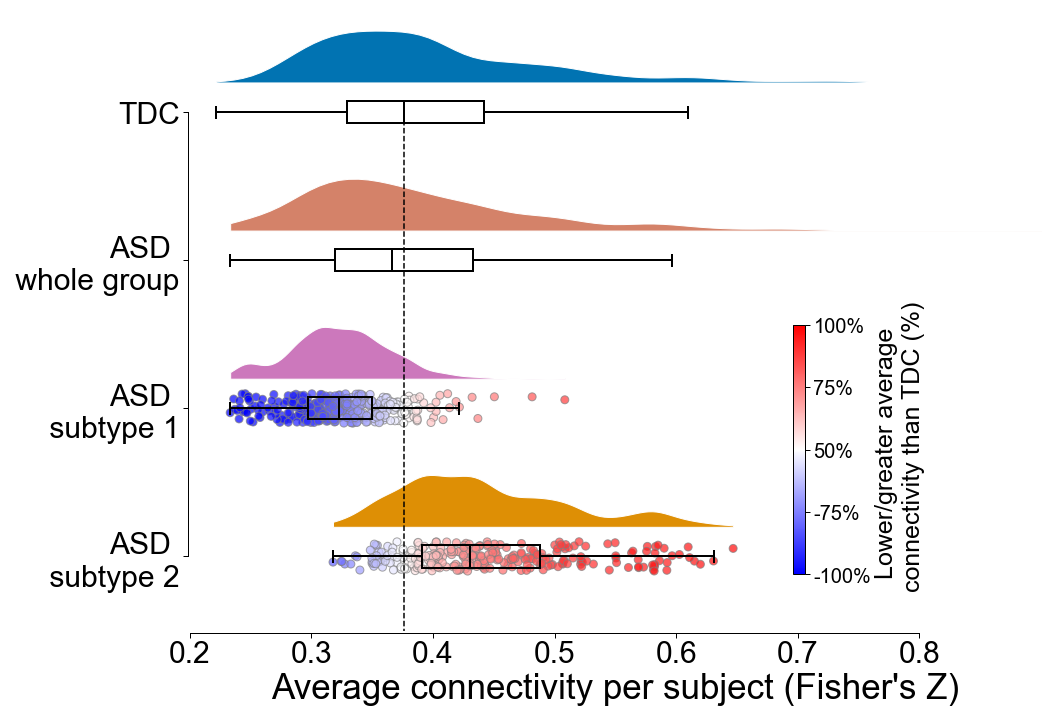

In [8]:
offset = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0., vmax=0.5)
cmap_scalarmap = cm.ScalarMappable(norm=offset, cmap='bwr')

mpl.rcParams['font.family'] = 'Arial'
sns.set_context("paper")
current_palette=sns.color_palette('colorblind')

fig, ax = plt.subplots(figsize=(15, 10))

ptitprince.RainCloud(x='labels', y='conn', 
                     data=plot_df, 
                     ax=ax,  point_size=8, orient='h', scale='width',
                     edgecolor='black', **{'box_linewidth':2,
                                           'rain_alpha':1,
                                           'rain_linewidth':1,
                                           'rain_edgecolor':'grey',
                                           'box_fliersize':0}
                    )

ax.set_xlabel("Average connectivity per subject (Fisher's Z)", fontsize=35)
ax.tick_params(labelsize=30)
ax.set_ylabel("")
ax.set_xlim([0.2, 0.9])
sns.despine(offset=2, trim=True)

# Modify colors
ax.collections[0].set(facecolor=current_palette[0], edgecolor='white')
ax.collections[1].set(facecolor="#D48269", edgecolor='white')
ax.collections[2].set(facecolor=current_palette[4], edgecolor='white')
ax.collections[3].set(facecolor=current_palette[1], edgecolor='white')

ax.collections[4].set(facecolor="white", alpha=0.0)
ax.collections[5].set(facecolor="white", alpha=0.0)
ax.collections[6].set(facecolor=cmap_scalarmap.to_rgba(props_1), alpha=0.7)
ax.collections[7].set(facecolor=cmap_scalarmap.to_rgba(props_2), alpha=0.7)

plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
cb = plt.colorbar(cmap_scalarmap, shrink=0.4, location="right", pad=-0.35, anchor=(0,0.15))
cb.set_ticks([-0.5, -0.25, 0, 0.25, 0.5])
cb.set_ticklabels(["-100%", "-75%", "50%", "75%", "100%"])
cb.ax.set_ylabel("Lower/greater average \n connectivity than TDC (%)", size=25)
cb.ax.tick_params(labelsize=20) 
ymin, ymax = ax.get_ylim()
ax.vlines(x=plot_df[plot_df.labels=="TDC"].conn.median(), ymin=0, ymax=4, 
          colors="black",
          linestyles="--", linewidth=1.5)
ax.set_yticklabels(["TDC", "ASD \n whole group", 
                    "ASD \n subtype 1", 
                    "ASD \n subtype 2"])

plt.tight_layout()
plt.savefig(opj(plot_dir, "Figure2_v2.svg", dpi=600)

In [8]:
print(data_global_df_mean[data_global_df_mean.clus_id_euclidean==0].conn.mean())
print(data_global_df_mean[data_global_df_mean.clus_id_euclidean!=0].conn.mean())
print(data_global_df_mean[data_global_df_mean.clus_id_euclidean==1].conn.mean())
print(data_global_df_mean[data_global_df_mean.clus_id_euclidean==2].conn.mean())

0.3968658521851528
0.3915743036425923
0.32426311417654263
0.4444032187106656


In [9]:
print(data_global_df_mean[data_global_df_mean.clus_id_euclidean==0].conn_all.mean())
print(data_global_df_mean[data_global_df_mean.clus_id_euclidean!=0].conn_all.mean())
print(data_global_df_mean[data_global_df_mean.clus_id_euclidean==1].conn_all.mean())
print(data_global_df_mean[data_global_df_mean.clus_id_euclidean==2].conn_all.mean())

0.33291686857730235
0.3208864675504353
0.22512273378912082
0.404679621401067


In [11]:
import statsmodels.formula.api as smf
cond = (data_global_df_mean.clus_id_euclidean == 1) | (data_global_df_mean.clus_id_euclidean == 2)
smf.ols('conn ~ C(clus_id_euclidean) + AGE_AT_SCAN + C(SEX) + FD_mean', 
        data = data_global_df_mean.loc[cond,:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   conn   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     254.0
Date:                Sun, 15 Jan 2023   Prob (F-statistic):          1.39e-129
Time:                        16:50:47   Log-Likelihood:                 985.96
No. Observations:                 632   AIC:                            -1962.
Df Residuals:                     627   BIC:                            -1940.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2611      0.007     39.168      0.000       0.248       0.274
C(clus_id_euclidean)[T.2]     0.1207      0.004     29.536      0.000       0.113       0.129
C(SEX)[T.2]                   0.0127      0.006      2.187      0.029       0.001       0.024
AGE_AT_SCAN                   0.0003      0.000      1.566      0.118   -8.74e-05       0.001
FD_mean                       0.3652      0.030     12.005      0.000       0.305       0.425
==============================================================================
Omnibus:                       28.393   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.072
Skew:                           0.516   Prob(JB):                     1.79e-07
Kurtosis:                       3.341   Cond. No.                         293.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
import statsmodels.formula.api as smf
cond = (data_global_df_mean.clus_id_euclidean == 1) | (data_global_df_mean.clus_id_euclidean == 2)

smf.ols('conn_all ~ C(clus_id_euclidean) + AGE_AT_SCAN + C(SEX) + FD_mean', 
        data = data_global_df_mean.loc[cond,:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               conn_all   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     347.9
Date:                Sun, 15 Jan 2023   Prob (F-statistic):          1.43e-157
Time:                        16:51:00   Log-Likelihood:                 846.14
No. Observations:                 632   AIC:                            -1682.
Df Residuals:                     627   BIC:                            -1660.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.1436      0.008     17.267      0.000       0.127       0.160
C(clus_id_euclidean)[T.2]     0.1802      0.005     35.346      0.000       0.170       0.190
C(SEX)[T.2]                   0.0136      0.007      1.880      0.061      -0.001       0.028
AGE_AT_SCAN                   0.0006      0.000      2.368      0.018       0.000       0.001
FD_mean                       0.4515      0.038     11.895      0.000       0.377       0.526
==============================================================================
Omnibus:                        9.453   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.720
Skew:                           0.296   Prob(JB):                      0.00775
Kurtosis:                       2.865   Cond. No.                         293.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""